In [1]:
# Import packages
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [2]:
# Import other packages
from keras import layers,losses,metrics,activations,callbacks,initializers,regularizers,optimizers
import numpy as np
import pandas as pd
import os,datetime,pickle,sklearn
from sklearn import preprocessing,model_selection
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf

In [3]:
# Load data
FILE_PATH = os.path.join(os.getcwd(),'dataset','ecommerceDataset.csv')
df = pd.read_csv(FILE_PATH, names=["category","text"])
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  50425 non-null  object
 1   text      50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [4]:
# Observe few rows
df.head()

,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [5]:
# Data inspection
print(df['text'][0])
print(df['category'][0])
nClass = len(df['category'].unique())
print("Categories: ", df['category'].unique())
print("Number of categories: ", nClass)

Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss

In [6]:
# Observe missing values and duplicated
print("Missing values:\n", df.isna().sum())
print("Duplicates: ", df.duplicated().sum())

Missing values:
 category    0
text        1
dtype: int64
Duplicates:  22622


In [7]:
# Drop missing values
df.dropna(inplace=True)

In [8]:
# Test by creating a new copy of the DF, then remove the duplicates
df_copy = df.copy()
df_copy = df_copy.drop_duplicates()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27802 entries, 0 to 50410
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  27802 non-null  object
 1   text      27802 non-null  object
dtypes: object(2)
memory usage: 651.6+ KB


In [9]:
# Observe missing values and duplicated for drop duplicate df
print("Missing values:\n", df_copy.isna().sum())
print("Duplicates: ", df_copy.duplicated().sum())

Missing values:
 category    0
text        0
dtype: int64
Duplicates:  0


In [10]:
# Compare label distribution
print("Label distribution from original:\n", df['category'].value_counts())
print("Label distribution after removing duplicates:\n", df_copy['category'].value_counts())

Label distribution from original:
 category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64
Label distribution after removing duplicates:
 category
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: count, dtype: int64


In [11]:
# Split into feature and label
feature = df_copy['text'].values
label = df_copy['category'].values
# Encode the label
encoder = preprocessing.LabelEncoder()
label_encoded = encoder.fit_transform(label)
print(np.unique(label_encoded))

#save encoder
with open ("encoder.pkl","wb") as file:
    pickle.dump(encoder,file)

[0 1 2 3]


In [12]:
# Data splitting
seed = 42
x_train,x_split,y_train,y_split = model_selection.train_test_split(feature,label_encoded,train_size=0.7,random_state=seed)
x_val,x_test,y_val,y_test = model_selection.train_test_split(x_split,y_split,test_size=0.5,random_state=seed)

In [13]:
# NLP processes
# Tokenization
vocab_size = 7000
tokenizer = keras.layers.TextVectorization(max_tokens=vocab_size,output_sequence_length=300)
tokenizer.adapt(x_train)

In [14]:
# Test out the tokenizer
print(tokenizer.get_vocabulary())
sample_texts = x_train[:2]
sample_tokens = tokenizer(sample_texts)
print(sample_texts[0])
print(sample_tokens[0])

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of'), np.str_('to'), np.str_('a'), np.str_('for'), np.str_('in'), np.str_('with'), np.str_('is'), np.str_('your'), np.str_('you'), np.str_('it'), np.str_('this'), np.str_('on'), np.str_('from'), np.str_('that'), np.str_('or'), np.str_('as'), np.str_('are'), np.str_('can'), np.str_('be'), np.str_('an'), np.str_('has'), np.str_('all'), np.str_('at'), np.str_('by'), np.str_('will'), np.str_('x'), np.str_('set'), np.str_('use'), np.str_('1'), np.str_('book'), np.str_('not'), np.str_('made'), np.str_('quality'), np.str_('its'), np.str_('which'), np.str_('have'), np.str_('about'), np.str_('product'), np.str_('easy'), np.str_('he'), np.str_('also'), np.str_('size'), np.str_('up'), np.str_('one'), np.str_('our'), np.str_('more'), np.str_('design'), np.str_('home'), np.str_('author'), np.str_('2'), np.str_('any'), np.str_('cotton'), np.str_('new'), np.str_('high'), np.str_('black'), np.str_('we'), np.str_('his'), np.str_('color'), np.str_('

In [15]:
# Embedding
embedding = layers.Embedding(input_dim=vocab_size,output_dim=64)

In [16]:
# Test the embedding layer
sample_embedding = embedding(sample_tokens)
print(sample_embedding[0])

tf.Tensor(
[[-0.01699612  0.04437721 -0.02982756 ... -0.03173367  0.03985533
  -0.04607315]
 [-0.02466495  0.00104375  0.04593414 ...  0.01512077  0.03073961
  -0.0010183 ]
 [ 0.02115091 -0.02530576  0.02239344 ... -0.01241504 -0.01193601
  -0.03164517]
 ...
 [-0.04578469 -0.01191026 -0.00423704 ...  0.03169061 -0.00506126
   0.03818873]
 [-0.04578469 -0.01191026 -0.00423704 ...  0.03169061 -0.00506126
   0.03818873]
 [-0.04578469 -0.01191026 -0.00423704 ...  0.03169061 -0.00506126
   0.03818873]], shape=(300, 64), dtype=float32)


In [19]:
# Create the keras model
model = keras.Sequential()
# Add the NLP layers
model.add(tokenizer)
model.add(embedding)
# Add RNN layers
l2 = regularizers.L2()
model.add(layers.Bidirectional(layers.LSTM(8,return_sequences=True,kernel_regularizer=l2)))
model.add(layers.Bidirectional(layers.LSTM(8,return_sequences=False,kernel_regularizer=l2)))
model.add(layers.Dense(nClass,activation='softmax'))

In [20]:
# Compile the model
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer="adam",loss=loss,metrics=['accuracy'])

In [21]:
# Include mlflow into the workflow
mlflow.set_experiment("E-commerce products classification")

<Experiment: artifact_location='file:///c:/Users/suhaimi/Desktop/YPAI11/Capstone/capstone2_afiq/mlruns/292403646403644942', creation_time=1741658003634, experiment_id='292403646403644942', last_update_time=1741658003634, lifecycle_stage='active', name='E-commerce products classification', tags={}>

In [22]:
# Train model, include the logging into mlflow
es = callbacks.EarlyStopping(patience=3,verbose=1)
with mlflow.start_run() as run:
    mlflow_callback = mlflow.keras.MlflowCallback(run)
    run_id = run.info.run_id
    log_path = f"logs/{run_id}"
    ts = callbacks.TensorBoard(log_dir=log_path)
    history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=64,epochs=15,callbacks=[es,mlflow_callback,ts])
    mlflow.keras.save.log_model(model,artifact_path="model")

2025/03/11 15:48:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'NoneType' object is not subscriptable


Epoch 1/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.5171 - loss: 1.7966 - val_accuracy: 0.8333 - val_loss: 0.7816
Epoch 2/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8770 - loss: 0.5851 - val_accuracy: 0.8835 - val_loss: 0.4598
Epoch 3/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.9313 - loss: 0.3308 - val_accuracy: 0.9319 - val_loss: 0.3144
Epoch 4/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9594 - loss: 0.2189 - val_accuracy: 0.9360 - val_loss: 0.2800
Epoch 5/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9639 - loss: 0.1837 - val_accuracy: 0.9422 - val_loss: 0.2664
Epoch 6/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9712 - loss: 0.1613 - val_accuracy: 0.9192 - val_loss: 0.2988
Epoch 7/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9706 - loss: 0.1547 - val_accuracy: 0.9374 - val_loss: 0.2620
Epoch 8/15
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9763 - loss: 0

2025/03/11 15:55:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/11 15:55:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


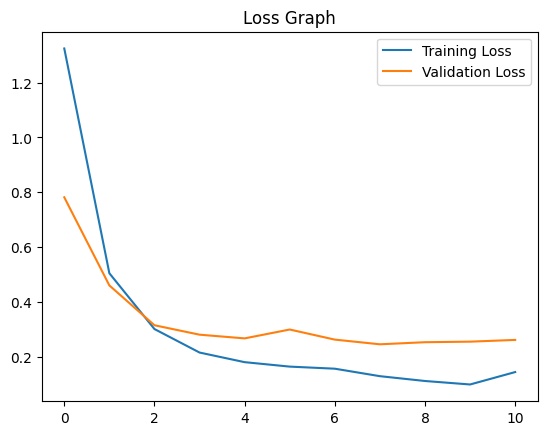

In [23]:
# Plot the graph of loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Graph")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

In [24]:
# Evaluate the model with test data
model.evaluate(x_test,y_test)

131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9386 - loss: 0.2858


[0.2728786766529083, 0.9400623440742493]

In [25]:
# Use the model to make prediction
y_pred = model.predict(x_test)
print(y_pred[0])
y_pred_class = np.argmax(y_pred,axis=1)
print(y_pred_class[0])
y_pred_it = encoder.inverse_transform(y_pred_class)
print(y_pred_it[0])

131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
[0.00926489 0.0418952  0.94585764 0.00298235]
2
Electronics


In [26]:
# Evaluae f1_score
f1 = f1_score(y_test, y_pred_class, average='weighted')
print(f'Weighted F1 Score: {f1}')

Weighted F1 Score: 0.9400836790733701
